In [21]:
import numpy as np
from fractions import Fraction
directory = 'lorenz/'


dyn_lorenz = {"sigma":16.0, "R":45.92, "b": 4.0}
x0 = np.array([10.0, 1.0, 0.0])

def lorenz (x0, dyn):
    sigma = dyn['sigma']
    R = dyn['R']
    b = dyn['b']
    x = x0[0]
    y = x0[1]
    z = x0[2]
    return np.array([sigma * (y - x), x * (R - z) - y, x * y - b * z])


def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn)*dt #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1,dyn)*dt
    k3 = f(x0 + 0.5*k2, dyn)*dt
    k4 = f(x0 + k3, dyn)*dt
    
    x = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    return x

def f_t (dyn, f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    print(x.shape)      
    for i in range(1,T):
        x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1]) 
    return x




In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = f_t(dyn_lorenz, lorenz, 0.01, x0, 50000)


(3, 50000)


/tmp/ipykernel_10306/613947110.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


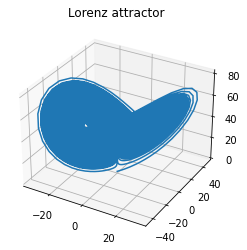

In [23]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[0], x[1], x[2])
plt.title('Lorenz attractor')
plt.draw()
plt.savefig(directory + 'Lorenz_attractor.png')

In [24]:
evolv_start = 1.5
taus = [1/12,3/4,1.5]
evolvs =  [evolv_start/2, evolv_start, evolv_start*2]

In [25]:
for tau in taus:
    for evolv in evolvs:

        IND = 0
        SUM = 0.0
        ITS = 0
        IND2 = 0

        DI = 1.e38 #any large number

        NPT = len(x[0])
        DIM = 3 #is dimension 12 ?
        dt = 0.01
        TAU_physical = tau #no TAU if full state
        TAU = int(TAU_physical/dt)
        SCALMX = 20
        SCALMN = 10
        EVOLV_physical = evolv #time from t0 to t1
        EVOLV = int(EVOLV_physical/dt)

        NPT = NPT - DIM*TAU - EVOLV

        Z = np.empty([NPT,DIM])

        #Z(I,J)=JTH COMPONENT OF ITH RECONSTRUCTED ATTRACTOR POINT
        for i in range(int(NPT)):
            for j in range(DIM):

                Z[i][j] = x[0][i + (j-1)*TAU]

        fig = plt.figure()
        ax = fig.gca(projection="3d")
        ax.plot(Z[:,0], Z[:,1], Z[:,2])
        plt.title('Lorenz attractor with tau = {a} & evolv = {b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical) )
        plt.savefig(directory + 'Lorenz_attractor'+ '_tau{a}evolv{b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical) +'.png')
        plt.clf() 
        #find nearest neighbor to the first data point
        for i in range(1, int(NPT)):
            D = 0.0
            #iterate through the array, compare first point with the rest
            D = np.linalg.norm(Z[IND] - Z[i])
            if ((D<DI) and (D>=SCALMN)):
                DI = D
                IND2 = i
        SUM_list = []
        while ((IND + EVOLV < NPT) and (IND2 + EVOLV < NPT)): #40
            PT1 = Z[IND+EVOLV] #would this be the dimesion
            PT2 = Z[IND2+EVOLV]
            DF = np.linalg.norm(PT1 - PT2)
            ITS = ITS + 1
            SUM_list.append(SUM)
            SUM = SUM + np.log2(DF/DI)/EVOLV_physical
            ZLYAP = SUM/float(ITS)
            INDOLD = IND2
            ZMULT = 1.0
            ANGLMX = 0.3
            #THMIN = 3.14
            while (True): #70
                #print("here")
                THMIN = 3.14

                for i in range (int(NPT)): #100
                    III = int(np.absolute(i-(IND+EVOLV)))
                    if (III >= 10):
                        #find angular change old to new vector
                        DNEW = 0.0
                        DNEW = np.linalg.norm(PT1 - Z[i])
                        if ((DNEW <= ZMULT*SCALMX) and (DNEW >= SCALMN)):
                            DOT = 0.0
                            DOT = np.dot((PT1 - Z[i]),(PT1 - PT2))
                            CTH = np.absolute(DOT/(DNEW*DF))
                            #print(CTH)
                            if (CTH > 1.0):
                                CTH = 1.0
                            TH = np.arccos(CTH)
                            #save smallest angular change so far
                            if TH <= THMIN:
                                THMIN = TH
                                DII = DNEW
                                IND2 = i
                if (THMIN < ANGLMX):
                    #print ("here")
                    break
                # look at longer distance if cant find replacement
                ZMULT = ZMULT + 1
                if (ZMULT > 5):
                    #no replacement at 5*scale, double search angle, reset distance
                    ZMULT = 1.0
                    ANGLMX = 2.0*ANGLMX
                if (ANGLMX >= 3.14):
                    IND2 = INDOLD + EVOLV
                    DII = DF
            IND = IND + EVOLV
            if (IND > NPT):
                print('here')
                break
            print ("IND, IND2, NPT", IND, IND2, NPT)
            DI = DII
        plt.plot(SUM_list)
        #plt.scatter(range(len(SUM_list)),SUM_list)
        plt.title('Accumulated lyapunov exponents with tau = {a} & evolv = {b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical))
        plt.ylabel('lyapunov exponents')
        plt.xlabel('iteration')
        plt.savefig(directory + 'Lorenz_LE'+ '_tau{a}evolv{b}'.format(a=round(TAU_physical, 3), b=EVOLV_physical) +'.png')
        plt.clf()


/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 75 38337 49901
IND, IND2, NPT 150 38412 49901
IND, IND2, NPT 225 38487 49901
IND, IND2, NPT 300 38562 49901
IND, IND2, NPT 375 23454 49901
IND, IND2, NPT 450 42441 49901
IND, IND2, NPT 525 42516 49901
IND, IND2, NPT 600 17932 49901
IND, IND2, NPT 675 18085 49901
IND, IND2, NPT 750 18160 49901
IND, IND2, NPT 825 17669 49901
IND, IND2, NPT 900 17744 49901
IND, IND2, NPT 975 17819 49901
IND, IND2, NPT 1050 17894 49901
IND, IND2, NPT 1125 48379 49901
IND, IND2, NPT 1200 48454 49901
IND, IND2, NPT 1275 17669 49901
IND, IND2, NPT 1350 17744 49901
IND, IND2, NPT 1425 17819 49901
IND, IND2, NPT 1500 17894 49901
IND, IND2, NPT 1575 48379 49901
IND, IND2, NPT 1650 48454 49901
IND, IND2, NPT 1725 17669 49901
IND, IND2, NPT 1800 17744 49901
IND, IND2, NPT 1875 17819 49901
IND, IND2, NPT 1950 17894 49901
IND, IND2, NPT 2025 48379 49901
IND, IND2, NPT 2100 48454 49901
IND, IND2, NPT 2175 17669 49901
IND, IND2, NPT 2250 17744 49901
IND, IND2, NPT 2325 17819 49901
IND, IND2, NPT 2400 17

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 150 26886 49826
IND, IND2, NPT 300 27036 49826
IND, IND2, NPT 450 39318 49826
IND, IND2, NPT 600 39507 49826
IND, IND2, NPT 750 17669 49826
IND, IND2, NPT 900 17819 49826
IND, IND2, NPT 1050 48379 49826
IND, IND2, NPT 1200 17669 49826
IND, IND2, NPT 1350 17819 49826
IND, IND2, NPT 1500 48379 49826
IND, IND2, NPT 1650 17669 49826
IND, IND2, NPT 1800 17819 49826
IND, IND2, NPT 1950 48379 49826
IND, IND2, NPT 2100 17669 49826
IND, IND2, NPT 2250 17819 49826
IND, IND2, NPT 2400 48379 49826
IND, IND2, NPT 2550 17669 49826
IND, IND2, NPT 2700 17819 49826
IND, IND2, NPT 2850 48379 49826
IND, IND2, NPT 3000 17669 49826
IND, IND2, NPT 3150 17819 49826
IND, IND2, NPT 3300 48379 49826
IND, IND2, NPT 3450 17669 49826
IND, IND2, NPT 3600 17819 49826
IND, IND2, NPT 3750 24054 49826
IND, IND2, NPT 3900 26574 49826
IND, IND2, NPT 4050 49173 49826
IND, IND2, NPT 4200 6577 49826
IND, IND2, NPT 4350 13786 49826
IND, IND2, NPT 4500 13936 49826
IND, IND2, NPT 4650 10049 49826
IND, IND2, NPT 

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 300 27036 49676
IND, IND2, NPT 600 27336 49676
IND, IND2, NPT 900 33571 49676
IND, IND2, NPT 1200 32687 49676
IND, IND2, NPT 1500 29416 49676
IND, IND2, NPT 1800 16781 49676
IND, IND2, NPT 2100 17081 49676
IND, IND2, NPT 2400 17381 49676
IND, IND2, NPT 2700 17681 49676
IND, IND2, NPT 3000 3678 49676
IND, IND2, NPT 3300 3678 49676
IND, IND2, NPT 3600 3678 49676
IND, IND2, NPT 3900 8622 49676
IND, IND2, NPT 4200 47682 49676
IND, IND2, NPT 4500 35172 49676
IND, IND2, NPT 4800 35472 49676
IND, IND2, NPT 5100 40582 49676
IND, IND2, NPT 5400 34776 49676
IND, IND2, NPT 5700 28514 49676
IND, IND2, NPT 6000 34775 49676
IND, IND2, NPT 6300 35075 49676
IND, IND2, NPT 6600 49304 49676
IND, IND2, NPT 6900 31405 49676
IND, IND2, NPT 7200 9923 49676
IND, IND2, NPT 7500 27035 49676
IND, IND2, NPT 7800 27570 49676
IND, IND2, NPT 8100 11476 49676
IND, IND2, NPT 8400 11776 49676
IND, IND2, NPT 8700 32454 49676
IND, IND2, NPT 9000 21370 49676
IND, IND2, NPT 9300 49270 49676
IND, IND2, NPT 9

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 75 11263 49700
IND, IND2, NPT 150 11338 49700
IND, IND2, NPT 225 6931 49700
IND, IND2, NPT 300 7006 49700
IND, IND2, NPT 375 7081 49700
IND, IND2, NPT 450 43008 49700
IND, IND2, NPT 525 43083 49700
IND, IND2, NPT 600 24364 49700
IND, IND2, NPT 675 24439 49700
IND, IND2, NPT 750 23781 49700
IND, IND2, NPT 825 23856 49700
IND, IND2, NPT 900 23931 49700
IND, IND2, NPT 975 26972 49700
IND, IND2, NPT 1050 34505 49700
IND, IND2, NPT 1125 34580 49700
IND, IND2, NPT 1200 34655 49700
IND, IND2, NPT 1275 34730 49700
IND, IND2, NPT 1350 34805 49700
IND, IND2, NPT 1425 27211 49700
IND, IND2, NPT 1500 17338 49700
IND, IND2, NPT 1575 17413 49700
IND, IND2, NPT 1650 42986 49700
IND, IND2, NPT 1725 43061 49700
IND, IND2, NPT 1800 43136 49700
IND, IND2, NPT 1875 43211 49700
IND, IND2, NPT 1950 43286 49700
IND, IND2, NPT 2025 43361 49700
IND, IND2, NPT 2100 45231 49700
IND, IND2, NPT 2175 45306 49700
IND, IND2, NPT 2250 48231 49700
IND, IND2, NPT 2325 48306 49700
IND, IND2, NPT 2400 48381

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 150 11338 49625
IND, IND2, NPT 300 26548 49625
IND, IND2, NPT 450 17891 49625
IND, IND2, NPT 600 18041 49625
IND, IND2, NPT 750 44485 49625
IND, IND2, NPT 900 14433 49625
IND, IND2, NPT 1050 27137 49625
IND, IND2, NPT 1200 47435 49625
IND, IND2, NPT 1350 45842 49625
IND, IND2, NPT 1500 6317 49625
IND, IND2, NPT 1650 31832 49625
IND, IND2, NPT 1800 31982 49625
IND, IND2, NPT 1950 17891 49625
IND, IND2, NPT 2100 18041 49625
IND, IND2, NPT 2250 44485 49625
IND, IND2, NPT 2400 14433 49625
IND, IND2, NPT 2550 27137 49625
IND, IND2, NPT 2700 47435 49625
IND, IND2, NPT 2850 45842 49625
IND, IND2, NPT 3000 6317 49625
IND, IND2, NPT 3150 31832 49625
IND, IND2, NPT 3300 31982 49625
IND, IND2, NPT 3450 17891 49625
IND, IND2, NPT 3600 13995 49625
IND, IND2, NPT 3750 14145 49625
IND, IND2, NPT 3900 33431 49625
IND, IND2, NPT 4050 33581 49625
IND, IND2, NPT 4200 33731 49625
IND, IND2, NPT 4350 19996 49625
IND, IND2, NPT 4500 17085 49625
IND, IND2, NPT 4650 48842 49625
IND, IND2, NPT 4

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 300 26548 49475
IND, IND2, NPT 600 13731 49475
IND, IND2, NPT 900 8476 49475
IND, IND2, NPT 1200 41922 49475
IND, IND2, NPT 1500 42222 49475
IND, IND2, NPT 1800 27094 49475
IND, IND2, NPT 2100 34070 49475
IND, IND2, NPT 2400 34370 49475
IND, IND2, NPT 2700 43213 49475
IND, IND2, NPT 3000 13009 49475
IND, IND2, NPT 3300 13309 49475
IND, IND2, NPT 3600 43247 49475
IND, IND2, NPT 3900 48216 49475
IND, IND2, NPT 4200 19012 49475
IND, IND2, NPT 4500 19312 49475
IND, IND2, NPT 4800 25184 49475
IND, IND2, NPT 5100 25484 49475
IND, IND2, NPT 5400 25784 49475
IND, IND2, NPT 5700 28602 49475
IND, IND2, NPT 6000 11560 49475
IND, IND2, NPT 6300 25384 49475
IND, IND2, NPT 6600 10876 49475
IND, IND2, NPT 6900 40008 49475
IND, IND2, NPT 7200 21053 49475
IND, IND2, NPT 7500 21353 49475
IND, IND2, NPT 7800 38758 49475
IND, IND2, NPT 8100 13156 49475
IND, IND2, NPT 8400 13456 49475
IND, IND2, NPT 8700 17555 49475
IND, IND2, NPT 9000 44077 49475
IND, IND2, NPT 9300 44377 49475
IND, IND2, N

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 75 46368 49475
IND, IND2, NPT 150 22380 49475
IND, IND2, NPT 225 11445 49475
IND, IND2, NPT 300 35491 49475
IND, IND2, NPT 375 35566 49475
IND, IND2, NPT 450 35641 49475
IND, IND2, NPT 525 35716 49475
IND, IND2, NPT 600 20932 49475
IND, IND2, NPT 675 21007 49475
IND, IND2, NPT 750 21082 49475
IND, IND2, NPT 825 47548 49475
IND, IND2, NPT 900 24045 49475
IND, IND2, NPT 975 48340 49475
IND, IND2, NPT 1050 48415 49475
IND, IND2, NPT 1125 48490 49475
IND, IND2, NPT 1200 48565 49475
IND, IND2, NPT 1275 39284 49475
IND, IND2, NPT 1350 48307 49475
IND, IND2, NPT 1425 48382 49475
IND, IND2, NPT 1500 42479 49475
IND, IND2, NPT 1575 42554 49475
IND, IND2, NPT 1650 28895 49475
IND, IND2, NPT 1725 28970 49475
IND, IND2, NPT 1800 15905 49475
IND, IND2, NPT 1875 15980 49475
IND, IND2, NPT 1950 16055 49475
IND, IND2, NPT 2025 45226 49475
IND, IND2, NPT 2100 42908 49475
IND, IND2, NPT 2175 35135 49475
IND, IND2, NPT 2250 8246 49475
IND, IND2, NPT 2325 8321 49475
IND, IND2, NPT 2400 8396

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 150 32787 49400
IND, IND2, NPT 300 15432 49400
IND, IND2, NPT 450 15582 49400
IND, IND2, NPT 600 15732 49400
IND, IND2, NPT 750 18573 49400
IND, IND2, NPT 900 39303 49400
IND, IND2, NPT 1050 35608 49400
IND, IND2, NPT 1200 35758 49400
IND, IND2, NPT 1350 35908 49400
IND, IND2, NPT 1500 36058 49400
IND, IND2, NPT 1650 17502 49400
IND, IND2, NPT 1800 15074 49400
IND, IND2, NPT 1950 15224 49400
IND, IND2, NPT 2100 15374 49400
IND, IND2, NPT 2250 34628 49400
IND, IND2, NPT 2400 48307 49400
IND, IND2, NPT 2550 42479 49400
IND, IND2, NPT 2700 28895 49400
IND, IND2, NPT 2850 15905 49400
IND, IND2, NPT 3000 16055 49400
IND, IND2, NPT 3150 29495 49400
IND, IND2, NPT 3300 39162 49400
IND, IND2, NPT 3450 39312 49400
IND, IND2, NPT 3600 13120 49400
IND, IND2, NPT 3750 49077 49400
IND, IND2, NPT 3900 23272 49400
IND, IND2, NPT 4050 23422 49400
IND, IND2, NPT 4200 23572 49400
IND, IND2, NPT 4350 17973 49400
IND, IND2, NPT 4500 18123 49400
IND, IND2, NPT 4650 18273 49400
IND, IND2, NPT

/tmp/ipykernel_10306/910118282.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


IND, IND2, NPT 300 42035 49250
IND, IND2, NPT 600 42335 49250
IND, IND2, NPT 900 11143 49250
IND, IND2, NPT 1200 11443 49250
IND, IND2, NPT 1500 11743 49250
IND, IND2, NPT 1800 8213 49250
IND, IND2, NPT 2100 14377 49250
IND, IND2, NPT 2400 39465 49250
IND, IND2, NPT 2700 46205 49250
IND, IND2, NPT 3000 26734 49250
IND, IND2, NPT 3300 27034 49250
IND, IND2, NPT 3600 18711 49250
IND, IND2, NPT 3900 8044 49250
IND, IND2, NPT 4200 40815 49250
IND, IND2, NPT 4500 41115 49250
IND, IND2, NPT 4800 41415 49250
IND, IND2, NPT 5100 37292 49250
IND, IND2, NPT 5400 37592 49250
IND, IND2, NPT 5700 22304 49250
IND, IND2, NPT 6000 12676 49250
IND, IND2, NPT 6300 12976 49250
IND, IND2, NPT 6600 22633 49250
IND, IND2, NPT 6900 38785 49250
IND, IND2, NPT 7200 39085 49250
IND, IND2, NPT 7500 20665 49250
IND, IND2, NPT 7800 12101 49250
IND, IND2, NPT 8100 13939 49250
IND, IND2, NPT 8400 12259 49250
IND, IND2, NPT 8700 30748 49250
IND, IND2, NPT 9000 29864 49250
IND, IND2, NPT 9300 34814 49250
IND, IND2, NP

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>